<a href="https://colab.research.google.com/github/dillonkoh89/GA-Capstone/blob/main/Capstone_Part_3_Object_Detection_Loaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow==2.4.3

     |████████████████████████████████| 394.5 MB 385 bytes/s 
     |████████████████████████████████| 2.9 MB 45.1 MB/s 
     |████████████████████████████████| 462 kB 43.4 MB/s 
     |████████████████████████████████| 3.8 MB 34.6 MB/s 


In [2]:
import numpy as np
import os
import cv2
from PIL import Image
import zipfile
import os
import tensorflow as tf

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [3]:
# This cell is using the saved model and datasets from google drive
#mount drive
#from google.colab import drive
#drive.mount('/content/drive/')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
# !ln -s /content/drive/My\ Drive/ /mydrive

#list contents in your drive
# !ls /mydrive

In [4]:
# downloading zipped datasets from dropbox
!wget https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip

--2021-12-09 15:52:15--  https://www.dropbox.com/s/fxmoldrklrfhtui/TFlite.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fxmoldrklrfhtui/TFlite.zip [following]
--2021-12-09 15:52:15--  https://www.dropbox.com/s/raw/fxmoldrklrfhtui/TFlite.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1167d5f81041c6efb28aa20248.dl.dropboxusercontent.com/cd/0/inline/BbhitfnNd3K6dJrn-vTlwBUcZqpr-qNxZr7Eohx72M4KYHqyIRXE6ovPt1gcX-o0su7P2GeLnzhG4Cfy90FQFoL7iFI9ddzMDHrgJCLuYcBE1wactMHuMDwaeCuswNSFMuZv9u6owgvtG2lLDB0hPHZL/file# [following]
--2021-12-09 15:52:16--  https://uc1167d5f81041c6efb28aa20248.dl.dropboxusercontent.com/cd/0/inline/BbhitfnNd3K6dJrn-vTlwBUcZqpr-qNxZr7Eohx72M4KYHqyIRXE6ovPt1gcX-o0su7P2GeLnzhG4Cfy90FQFoL7iFI9d

In [5]:
#extracting the files in the downloaded classification.zip file
zip_ref = zipfile.ZipFile("TFlite.zip")
zip_ref.extractall() #Extracts the files into the /tmp folder
zip_ref.close()

In [11]:
%cd TFlite/
# Walk through the "full" data directory and list number of files
for dirpath, dirnames, filenames in os.walk("full"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

/content/TFlite
There are 3 directories and 0 images in 'full'.
There are 2 directories and 0 images in 'full/val'.
There are 0 directories and 232 images in 'full/val/images'.
There are 0 directories and 232 images in 'full/val/annotations'.
There are 2 directories and 0 images in 'full/test'.
There are 0 directories and 101 images in 'full/test/images'.
There are 0 directories and 100 images in 'full/test/annotations'.
There are 2 directories and 0 images in 'full/train'.
There are 0 directories and 881 images in 'full/train/images'.
There are 0 directories and 881 images in 'full/train/annotations'.


In [6]:
# Read the label.txt
with open('/content/TFlite/colab_models/tflite1/labels.txt', 'rb') as file:
    lines = []
    for line in file:
        lines.append(line.rstrip().decode())

# Load the labels into a list
# classes = ['helmet', 'person', 'safety vest']
classes = lines
print(classes)

['helmet', 'person', 'safety vest']


In [7]:
# opening the model.tflite file which was modelled in the previous notebook
with open('/content/TFlite/colab_models/tflite3/model.tflite', 'rb') as fid:
    tflite_model = fid.read()

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [8]:
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Return the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  # Run the inference
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, results

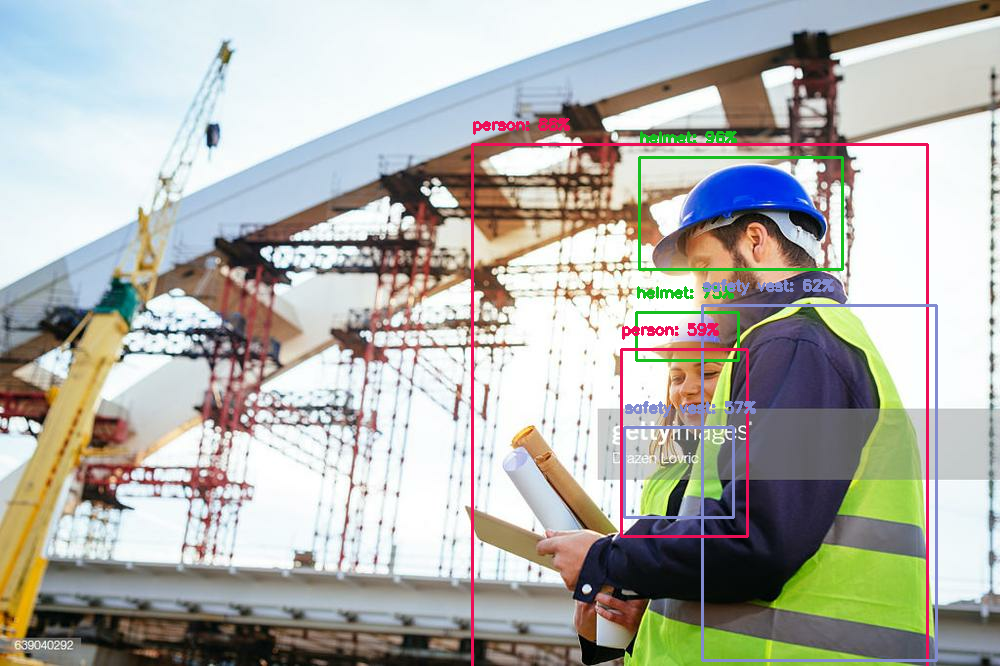

In [12]:
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_242.jpg'
DETECTION_THRESHOLD = 0.3

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)


In [13]:
print(results)

[{'bounding_box': array([0.23665419, 0.63932437, 0.40427658, 0.8424179 ], dtype=float32), 'class_id': 0.0, 'score': 0.95703125}, {'bounding_box': array([0.21718058, 0.47203523, 1.0067761 , 0.92796487], dtype=float32), 'class_id': 1.0, 'score': 0.87890625}, {'bounding_box': array([0.469844 , 0.6367266, 0.5415522, 0.7382734], dtype=float32), 'class_id': 0.0, 'score': 0.75}, {'bounding_box': array([0.45810926, 0.70271003, 0.9909915 , 0.9362109 ], dtype=float32), 'class_id': 2.0, 'score': 0.625}, {'bounding_box': array([0.52517664, 0.6216921 , 0.8055848 , 0.7475465 ], dtype=float32), 'class_id': 1.0, 'score': 0.58984375}, {'bounding_box': array([0.6425282 , 0.62419754, 0.77675855, 0.73366266], dtype=float32), 'class_id': 2.0, 'score': 0.57421875}]


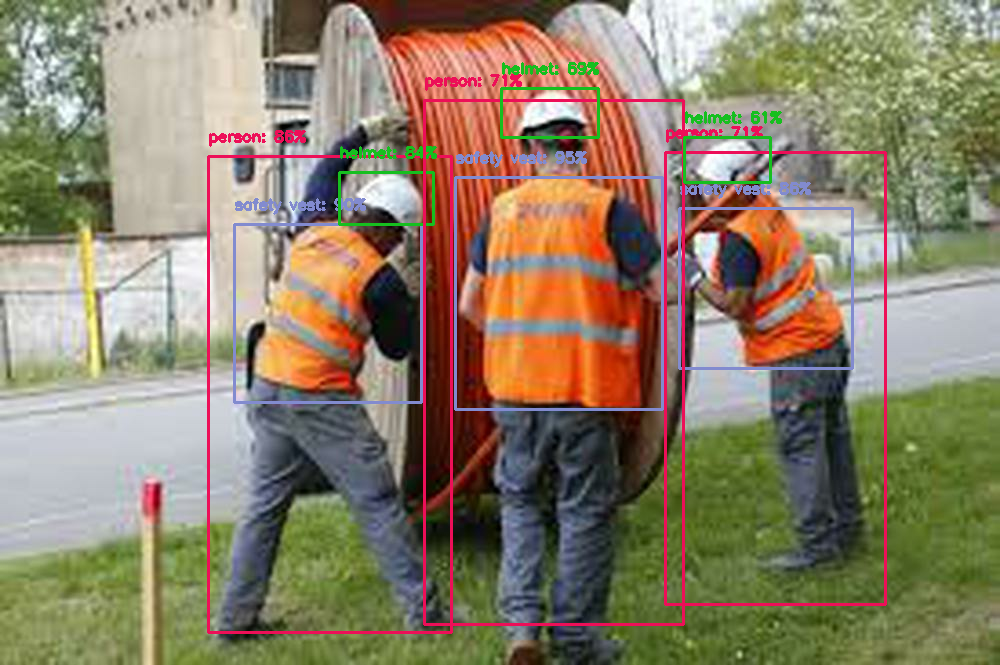

In [14]:
INPUT_IMAGE = '/content/TFlite/full/test/images/pos_3424.jpg'
DETECTION_THRESHOLD = 0.3

#This script will resize an image (somepic.jpg) using PIL (Python Imaging Library) to a width of 300 pixels and a height proportional to the new width. It does this by determining what percentage 300 pixels is of the original width (img.size[0]) and then multiplying the original height (img.size[1]) by that percentage. Change "basewidth" to any other number to change the default width of your images.
basewidth = 1000
img = Image.open(INPUT_IMAGE)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img.save('/content/TFlite/full/test/images/temp_resize.jpg')

temp_file = '/content/TFlite/full/test/images/temp_resize.jpg'

# Run inference and draw detection result on the local copy of the original file
detection_result_image, results = run_odt_and_draw_results(
    temp_file, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

Video Processing